In [13]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [14]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [15]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']
xnodes = isotropic1024coarse['xnodes']
ynodes = isotropic1024coarse['ynodes']
znodes = isotropic1024coarse['znodes']

In [16]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(my_id==0):
    print("rank = "+str(nproc))
    print("my_id = "+str(my_id))

[stdout:0] 
rank = 8
my_id = 0


In [17]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 1.024#0.0

chkSz = 32
slabs = nx//chkSz

In [18]:
%%px

vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True

folder = "/home/idies/workspace/scratch"
filename = "cache-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    ud = []
    for k in range(slabs):
        if(rank==0):
            print(k)
        start = np.array([rank*nx+k*chkSz, 0, 0],dtype=np.int)
        width = np.array([chkSz,ny,nz],dtype=np.int)
        #start = np.array([ 0, 0, rank*nx+k*chkSz],dtype=np.int)
        ud.append(lJHTDB.getRawData(time,start,width, 
                                    data_set = 'isotropic1024coarse',
                                    getFunction = 'Velocity') )
    
    lJHTDB.finalize()
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    u = np.concatenate(ud,axis=2)
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Concatenate: {0:.2f} seconds\n'.format(t1-t2))
    
    rsh = np.transpose(u,(2,1,0,3))
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Transpose: {0:.2f} seconds\n'.format(t2-t1))
    ##########################################
    
    vx[:,:,:] = rsh[:,:,:,0]
    vy[:,:,:] = rsh[:,:,:,1]
    vz[:,:,:] = rsh[:,:,:,2]
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Splitting: {0:.2f} seconds\n'.format(t2-t1))
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:0] 
Starting the loading process
Finished loading
Load from disk: 22.02 seconds
vx shape = (128, 1024, 1024)


In [19]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,my_id)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate all wavenumbers: 11.11 seconds


In [20]:
%%px 

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

In [21]:
%%px

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

In [22]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx[:,:,:] = fft.forward3Dfft(vx,nx,ny,nz,nproc,rank)
cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)
cvz[:,:,:] = fft.forward3Dfft(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate 3D spatial FFT: 84.18 seconds


In [23]:
%%px
comm.Barrier(); t1=MPI.Wtime()
## Get energy spectrum in Fourier space
ek_unfltrd=myEnergySpc.GetSpectrumFromComplexField(cvx,cvy,cvz,k2,nx,ny,nz,nek,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D energy spectra: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate 3D energy spectra: 28.13 seconds


In [39]:
%%px

spc = np.loadtxt("isotropic-spectra.txt")
kr,Ekr = spc.transpose()

[output:0]

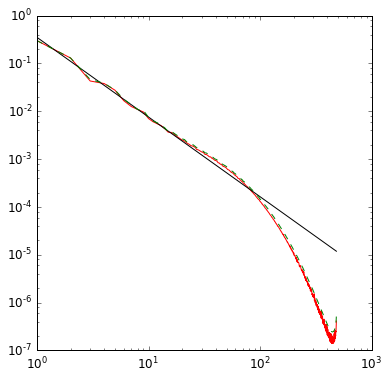

In [41]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
if my_id==0:
    SIZE = 12
    epsilon = 0.103
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))

    plt.loglog(ks,ek_unfltrd,'r',label='Unfiltered')
    plt.loglog(ks,1.6*(epsilon**(2/3))*np.power(ks,-5/3),'k')
    plt.loglog(kr,Ekr,'g--')

[output:0]

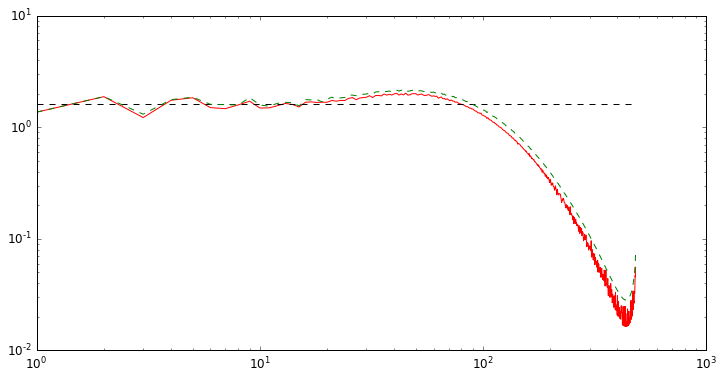

In [42]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
if my_id==0:
    SIZE = 12
    epsilon = 0.103
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(12,6))
    pl1=np.linspace(1,nek,nek)
    pl1[:] = 1.6

    plt.loglog(ks,ek_unfltrd*(epsilon**(-2/3))*np.power(ks,5/3),'r',label='Unfiltered')
    plt.loglog(ks,pl1,'k--')
    plt.loglog(kr,Ekr*(epsilon**(-2/3))*np.power(kr,5/3),'g--')
    #plt.loglog(ks,1.6,'k')